<a href="https://colab.research.google.com/github/viliturpeinen/Colabs/blob/Peliteoria11/Teht%C3%A4v%C3%A4_11_Peliteoria_ja_NashPy_kirjasto_Vili_Turpeinen_21112025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Peliteoria NashPy-kirjastolla - Ohjeet peruskäyttäjälle ja kehittäjälle

Asenna tarvittavat paketit (vain kerran):
pip install numpy matplotlib nashpy

In [9]:
pip install numpy matplotlib nashpy

In [10]:
import numpy as np
import nashpy as nash
import matplotlib.pyplot as plt



1. Pelin kuvaus

Pelin lähtötilanne: A:n strategioiden vaikutukset markkinaosuuksiin. Koska peli on nollasumma, B:n voitot ovat A:n tappioita eli B:n payoff = - (A:n payoff).

In [11]:

# Rivien määrä = A:n strategiat, sarakkeet = B:n strategiat
A_payoffs = np.array([
[ 3, -2, -1], # S1
[ -1, 0, 2], # S2
[ -1, 1, -1], # S3
[ -1, 2, -3] # S4
], dtype=float)


# B:n payoff on nollasummassa A:n payoffin negatiivinen
B_payoffs = -A_payoffs


# Luo peli NashPy:llä
game = nash.Game(A_payoffs, B_payoffs)
print(game)

Zero sum game with payoff matrices:

Row player:
[[ 3. -2. -1.]
 [-1.  0.  2.]
 [-1.  1. -1.]
 [-1.  2. -3.]]

Column player:
[[-3.  2.  1.]
 [ 1. -0. -2.]
 [ 1. -1.  1.]
 [ 1. -2.  3.]]


Korvaa A_payoffs-taulukon numerot niillä arvoilla, joita kuvasta luet.

2. Pelin tulosten kuvaus tietyillä strategioilla

Voit arvioida pelin tuloksen, jos pelaajat valitsevat joko puhtaan strategian (yksi vaihtoehto) tai sekamuodon (jakauma strategioiden välillä).

In [12]:
# Puhtaat strategiat: A valitsee S1 (indeksi 0), B valitsee S3 (indeksi 2)
sigmaA_pure = np.array([1,0,0,0])
sigmaB_pure = np.array([0,0,1]) # Korjattu: B:llä on 3 strategiaa, ei 4


# Odotetut voitot
exp_A = sigmaA_pure @ A_payoffs @ sigmaB_pure
exp_B = sigmaA_pure @ B_payoffs @ sigmaB_pure
print("Expected payoff A (pure):", exp_A)
print("Expected payoff B (pure):", exp_B)


# Sekastrategiat (esim. A sekoittaa S1 ja S3, B sekoittaa S2 ja S3)
sigmaA_mix = np.array([0.6, 0.0, 0.4, 0.0])
sigmaB_mix = np.array([0.0, 0.7, 0.3]) # Korjattu: B:llä on 3 strategiaa ja summan on oltava 1


exp_A_mix = sigmaA_mix @ A_payoffs @ sigmaB_mix
print("Expected payoff A (mixed):", exp_A_mix)

Expected payoff A (pure): -1.0
Expected payoff B (pure): 1.0
Expected payoff A (mixed): -0.8599999999999999


Selitys: Tuloksena saadaan odotusarvo A:n voitosta (negatiivinen tarkoittaa tappiota A:lle). Koska peli on nollasumma, B:n odotusarvo on vastaluku.

3. Nashin tasapainon laskeminen

Käytä NashPy:n support_enumeration -metodia (tai vertex_enumeration) löytääksesi Nash-equilibria.

In [13]:
equilibria = list(game.support_enumeration())
print("Found equilibria (sigmaA, sigmaB):")
for eq in equilibria:
    print(eq)

Found equilibria (sigmaA, sigmaB):
(array([0.25, 0.5 , 0.  , 0.25]), array([0.36363636, 0.45454545, 0.18181818]))


Mitä luvut tarkoittavat?

Kunkin parin (sigmaA, sigmaB) sisällä on kaksi vektoria: A:n todennäköisyysjakauma ja B:n todennäköisyysjakauma. Ne kertovat, millä todennäköisyyksillä kummankin pelaajan kannattaa valita kutakin puhdasta strategiaa niin, ettei kukaan yksin pysty parantamaan tulostaan vaihtamalla strategiaa.

Jos löydät äärellisiä (puhtaita) tasapainoja, ne näkyvät vektoreina, joissa yksi komponentti on 1 ja muut 0.

Sekatasapainot näkyvät jakaumina, esim. [0.4, 0.6, 0.0, 0.0].

Käytännön huomio: jos support_enumeration ei löydä mitään (harvinaista), kokeile vertex_enumeration().

4. Toistettujen pelien simulointi

Seuraava koodi simuloi yksinkertaista adaptatiivista oppimista (replicator-like), jossa kumpikin pelaaja päivittää strategiaansa suhteessa tuottoihin. Tämä ei ole tarkka biologinen replicator, mutta havainnollistaa, miten todennäköisyydet voivat suppeta tai hajaantua toistojen myötä.

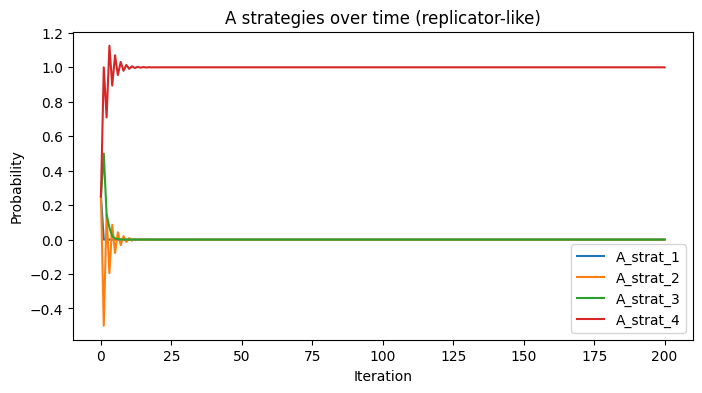

In [14]:
def replicator_update(sigma_player, expected_payoffs_for_player):
    # sigma_player: nykyinen sekoitusvektori (pituus m tai n)
    # expected_payoffs_for_player: odotetut tuotot kullekin sigma_playerin strategialle
    # Tämän tulee olla saman pituinen kuin sigma_player
    mean_payoff = sigma_player @ expected_payoffs_for_player
    # Päivitys: sigma_i <- sigma_i * (payoff_i / mean_payoff)
    # Lisää pientä regularisointia nollien välttämiseksi
    eps = 1e-8
    new_sigma = sigma_player * (expected_payoffs_for_player + eps) / (mean_payoff + eps)
    new_sigma /= new_sigma.sum()
    return new_sigma


# Simuloi toistoja
sigmaA = np.array([0.25, 0.25, 0.25, 0.25]) # A:lla on 4 strategiaa
sigmaB = np.array([1/3, 1/3, 1/3]) # B:llä on 3 strategiaa, korjattu alustus


historyA = [sigmaA.copy()]
historyB = [sigmaB.copy()]



for t in range(200):
    # Laske odotetut tuotot A:n strategioille B:n nykyisen strategian perusteella
    expected_payoffs_A_strategies = A_payoffs @ sigmaB
    # Päivitä sigmaA käyttämällä replikaattoridynamiikkaa
    sigmaA = replicator_update(sigmaA, expected_payoffs_A_strategies)

    # Laske odotetut tuotot B:n strategioille A:n nykyisen strategian perusteella
    expected_payoffs_B_strategies = sigmaA @ B_payoffs # Huomaa järjestys B:n osalta
    # Päivitä sigmaB käyttämällä replikaattoridynamiikkaa
    sigmaB = replicator_update(sigmaB, expected_payoffs_B_strategies)

    historyA.append(sigmaA.copy())
    historyB.append(sigmaB.copy())


historyA = np.array(historyA)
historyB = np.array(historyB)


# Piirretään A:n todennäköisyydet ajan funktiona
plt.figure(figsize=(8,4))
for i in range(historyA.shape[1]):
    plt.plot(historyA[:,i], label=f'A_strat_{i+1}')
plt.title('A strategies over time (replicator-like)')
plt.xlabel('Iteration')
plt.ylabel('Probability')
plt.legend()
plt.show()

Selitys kehittäjälle: Koodissa käytetään hyvin yksinkertaista päivitysälykää; todellisissa oppimismalleissa kannattaa käyttää selkeästi johdettua replicator- tai regret-mallia. Tämä riittää kuitenkin havainnollistamaan, suppeneeko jakauma kohti vähintään yhtä tasapainoa vai hajaantuuko.